In [2]:
import numpy as np 
import pandas as pd  
from sklearn.datasets import make_classification  # Para generar datasets sintéticos
from sklearn.model_selection import train_test_split, GridSearchCV  # Para dividir datos y optimizar hiperparámetros
from sklearn.preprocessing import StandardScaler  # Para estandarizar/normalizar características
from sklearn.linear_model import LogisticRegression  # El modelo de regresión logística
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, precision_recall_fscore_support, auc)  # Métricas de evaluación
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.impute import SimpleImputer

# Configuración para mejores visualizaciones
plt.style.use('default')
sns.set_palette("husl")

# Cargar dataset desde URL (dataset de enfermedades cardíacas)
# Fuente: UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

column_names = [ 'age', 'sex', 'cp', 'trestbps', 'chol','fbs', 'restecg', 'thalach',  'exang',
    'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Cargar los datos
try:
    df = pd.read_csv(url, names=column_names, na_values='?')
    print("✓ Dataset cargado exitosamente")
except Exception as e:
    print(f"Error cargando dataset: {e}")
    # Dataset de respaldo
    print("Usando dataset local de respaldo...")
    # En caso de error, podrías cargar un dataset local

# Información básica del dataset
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())

print("\nInformación de tipos de datos y nulos:")
df.info()


✓ Dataset cargado exitosamente
Dimensiones del dataset: (303, 14)

Primeras 5 filas:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Información de tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex  

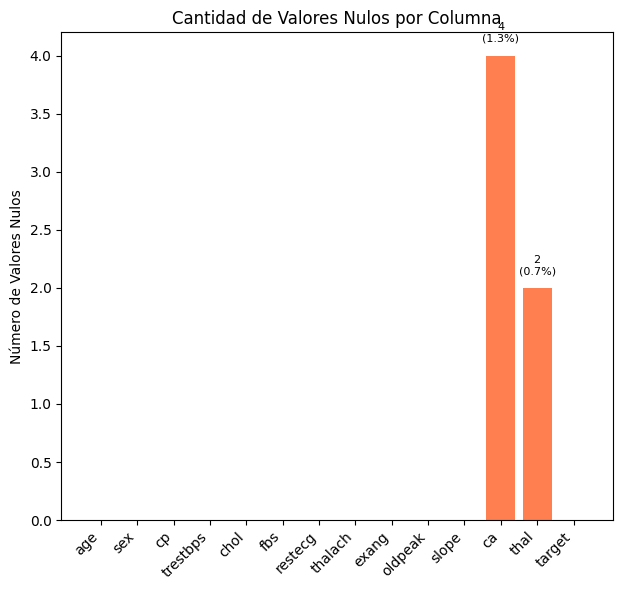

In [3]:

# VISUALIZACIÓN DE VALORES NULOS
plt.figure(figsize=(12, 6))


# Gráfico 2: Conteo de valores nulos por columna
plt.subplot(1, 2, 2)
null_counts = df.isnull().sum()
null_percent = (df.isnull().sum() / len(df)) * 100

bars = plt.bar(null_counts.index, null_counts.values, color='coral')
plt.title('Cantidad de Valores Nulos por Columna')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Número de Valores Nulos')

# Añadir porcentajes en las barras
for bar, count, percent in zip(bars, null_counts.values, null_percent.values):
    if count > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{count}\n({percent:.1f}%)', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [4]:
# PREPROCESAMIENTO DE DATOS
df['target_binary'] = (df['target'] > 0).astype(int)

print("Distribución de la variable objetivo original:")
print(df['target'].value_counts().sort_index())

# ESTO MUESTRA: cuántos pacientes hay en cada nivel de enfermedad
print("\nDistribución de la variable objetivo binaria:")
print(df['target_binary'].value_counts())
print(f"\nProporción de clases: {df['target_binary'].value_counts(normalize=True)}")

Distribución de la variable objetivo original:
target
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Distribución de la variable objetivo binaria:
target_binary
0    164
1    139
Name: count, dtype: int64

Proporción de clases: target_binary
0    0.541254
1    0.458746
Name: proportion, dtype: float64


In [5]:
print("\nManejando valores nulos...")

# Estrategia: imputar con la mediana (robusta a outliers)
imputer = SimpleImputer(strategy='median')

# Columnas con valores nulos
columns_with_nulls = ['ca', 'thal']
print(f"Columnas con nulos a imputar: {columns_with_nulls}")

# Imputar valores nulos
df_imputed = df.copy()
df_imputed[columns_with_nulls] = imputer.fit_transform(df[columns_with_nulls])

print("Valores nulos imputados con la mediana")

# Verificar que no hay nulos
print(f"\nValores nulos después de imputación: {df_imputed.isnull().sum().sum()}")




Manejando valores nulos...
Columnas con nulos a imputar: ['ca', 'thal']
Valores nulos imputados con la mediana

Valores nulos después de imputación: 0


In [6]:
# Definir X (características) - excluir columnas target
features = [col for col in df_imputed.columns if col not in ['target', 'target_binary']]
X = df_imputed[features]
y = df_imputed['target_binary']
print(f"\nDimensiones de X (características): {X.shape}")
print(f"Dimensiones de y (objetivo): {y.shape}")


Dimensiones de X (características): (303, 13)
Dimensiones de y (objetivo): (303,)


In [7]:
# DIVISIÓN EN ENTRENAMIENTO Y PRUEBA

X_train, X_test, y_train, y_test = train_test_split(
    X,                    # Características (X)
    y,                    # Variable objetivo (y)  
    test_size=0.25,       # 25% para prueba, 75% para entrenamiento
    random_state=42,      # Semilla para reproducibilidad
    stratify=y           # Mantener proporción de clases en ambos conjuntos
)

print(f"\nDIVISIÓN TRAIN-TEST:")
print(f"Entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")




DIVISIÓN TRAIN-TEST:
Entrenamiento: 227 muestras (74.9%)
Prueba: 76 muestras (25.1%)


In [8]:
# ESCALADO DE CARACTERÍSTICAS
scaler = StandardScaler()

# Ajustar scaler SOLO con datos de entrenamiento y transformar ambos conjuntos
X_train_scaled = scaler.fit_transform(X_train)  # Aprende parámetros de train
X_test_scaled = scaler.transform(X_test)        # Aplica misma transformación a test

print("Características escaladas (media=0, desviación=1)")
print(f"Media después del escalado: {np.mean(X_train_scaled, axis=0)[:3]}...")
print(f"Desviación estándar después del escalado: {np.std(X_train_scaled, axis=0)[:3]}...")



Características escaladas (media=0, desviación=1)
Media después del escalado: [-2.15197414e-17 -5.18430135e-17  7.82536053e-17]...
Desviación estándar después del escalado: [1. 1. 1.]...


In [9]:
# ENTRENAMIENTO DEL MODELO DE REGRESIÓN LOGÍSTICA

logreg = LogisticRegression(
    solver='liblinear',   # Algoritmo de optimización
    random_state=42,      # Reproducibilidad
    max_iter=1000         # Máximo número de iteraciones
)

logreg.fit(X_train_scaled, y_train) 

# Realizar predicciones
y_pred = logreg.predict(X_test_scaled)            # Clases predichas (0/1) - usa umbral 0.5
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  # Probabilidades de clase 1 - rango [0,1]


In [10]:
# CONCEPTO: Matriz de Confusión
# Muestra desempeño del modelo comparando predicciones vs valores reales
print("\nMATRIZ DE CONFUSIÓN:")
print("[[VN FP] - Verdaderos Negativos | Falsos Positivos")
print(" [FN VP]] - Falsos Negativos    | Verdaderos Positivos")

cm = confusion_matrix(y_test, y_pred)  # Calcula matriz: filas=real, columnas=predicho
print(f"\n{cm}")

# CONCEPTO: AUC-ROC
# Mide capacidad del modelo para distinguir entre clases
auc_score = roc_auc_score(y_test, y_proba)  # Calcula área bajo curva ROC (0-1)
print(f"AUC-ROC: {auc_score:.4f}")




MATRIZ DE CONFUSIÓN:
[[VN FP] - Verdaderos Negativos | Falsos Positivos
 [FN VP]] - Falsos Negativos    | Verdaderos Positivos

[[35  6]
 [ 4 31]]
AUC-ROC: 0.9310


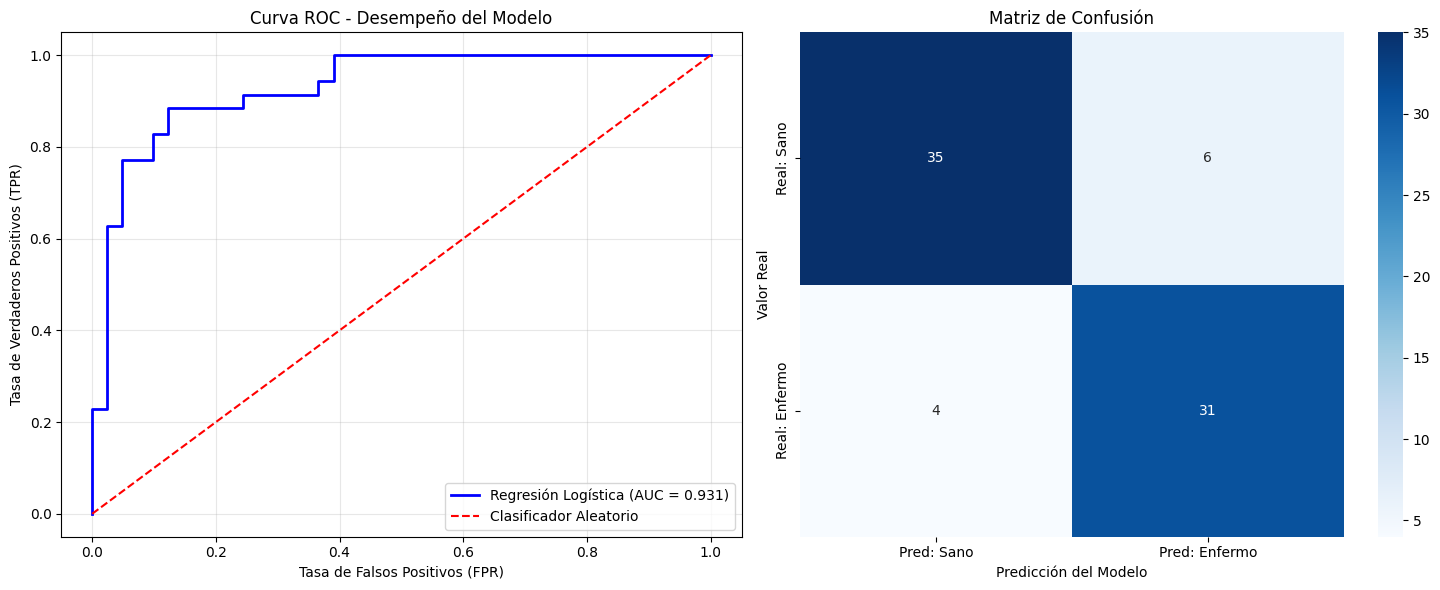

In [11]:
# VISUALIZACIONES

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Curva ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, label=f'Regresión Logística (AUC = {roc_auc:.3f})',
             linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], '--', label='Clasificador Aleatorio', color='red')
axes[0].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[0].set_title('Curva ROC - Desempeño del Modelo')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Matriz de Confusión 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Sano', 'Pred: Enfermo'],
            yticklabels=['Real: Sano', 'Real: Enfermo'],
            ax=axes[1])

axes[1].set_title('Matriz de Confusión')
axes[1].set_xlabel('Predicción del Modelo')
axes[1].set_ylabel('Valor Real')

plt.tight_layout()
plt.show()